In [1]:
# import the necessary libraries

import time
import gc
import os
import random

random_state = 42
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.environ['PYTHONHASHSEED'] = str(random_state)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
log_dir = os.path.join(os.curdir, 'logs')

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.color import rgba2rgb
from tensorflow import keras

random.seed(random_state) # random python seed, but fixed
np.random.seed(random_state) # random numpy seed, but fixed
tf.random.set_seed(random_state) # random tf seed, but fixed

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# define the image path
img_train_folder_set1 = r'dataset\pictures\train\64x64\set-1'
img_train_folder_set2 = r'dataset\pictures\train\64x64\set-2'
img_test_folder = r'dataset\pictures\test\64x64'

# define plot properties for dark IDE
font_size = 25
font_color = 'white'
plt.rc('axes', facecolor = '#1e1e1e')
plt.rc('figure', facecolor = '#1e1e1e')
plt.rc('axes', edgecolor = 'w')
plt.rc('xtick', color = 'w')
plt.rc('ytick', color = 'w')
plt.rc('legend', facecolor = 'w')

Num GPUs Available:  1


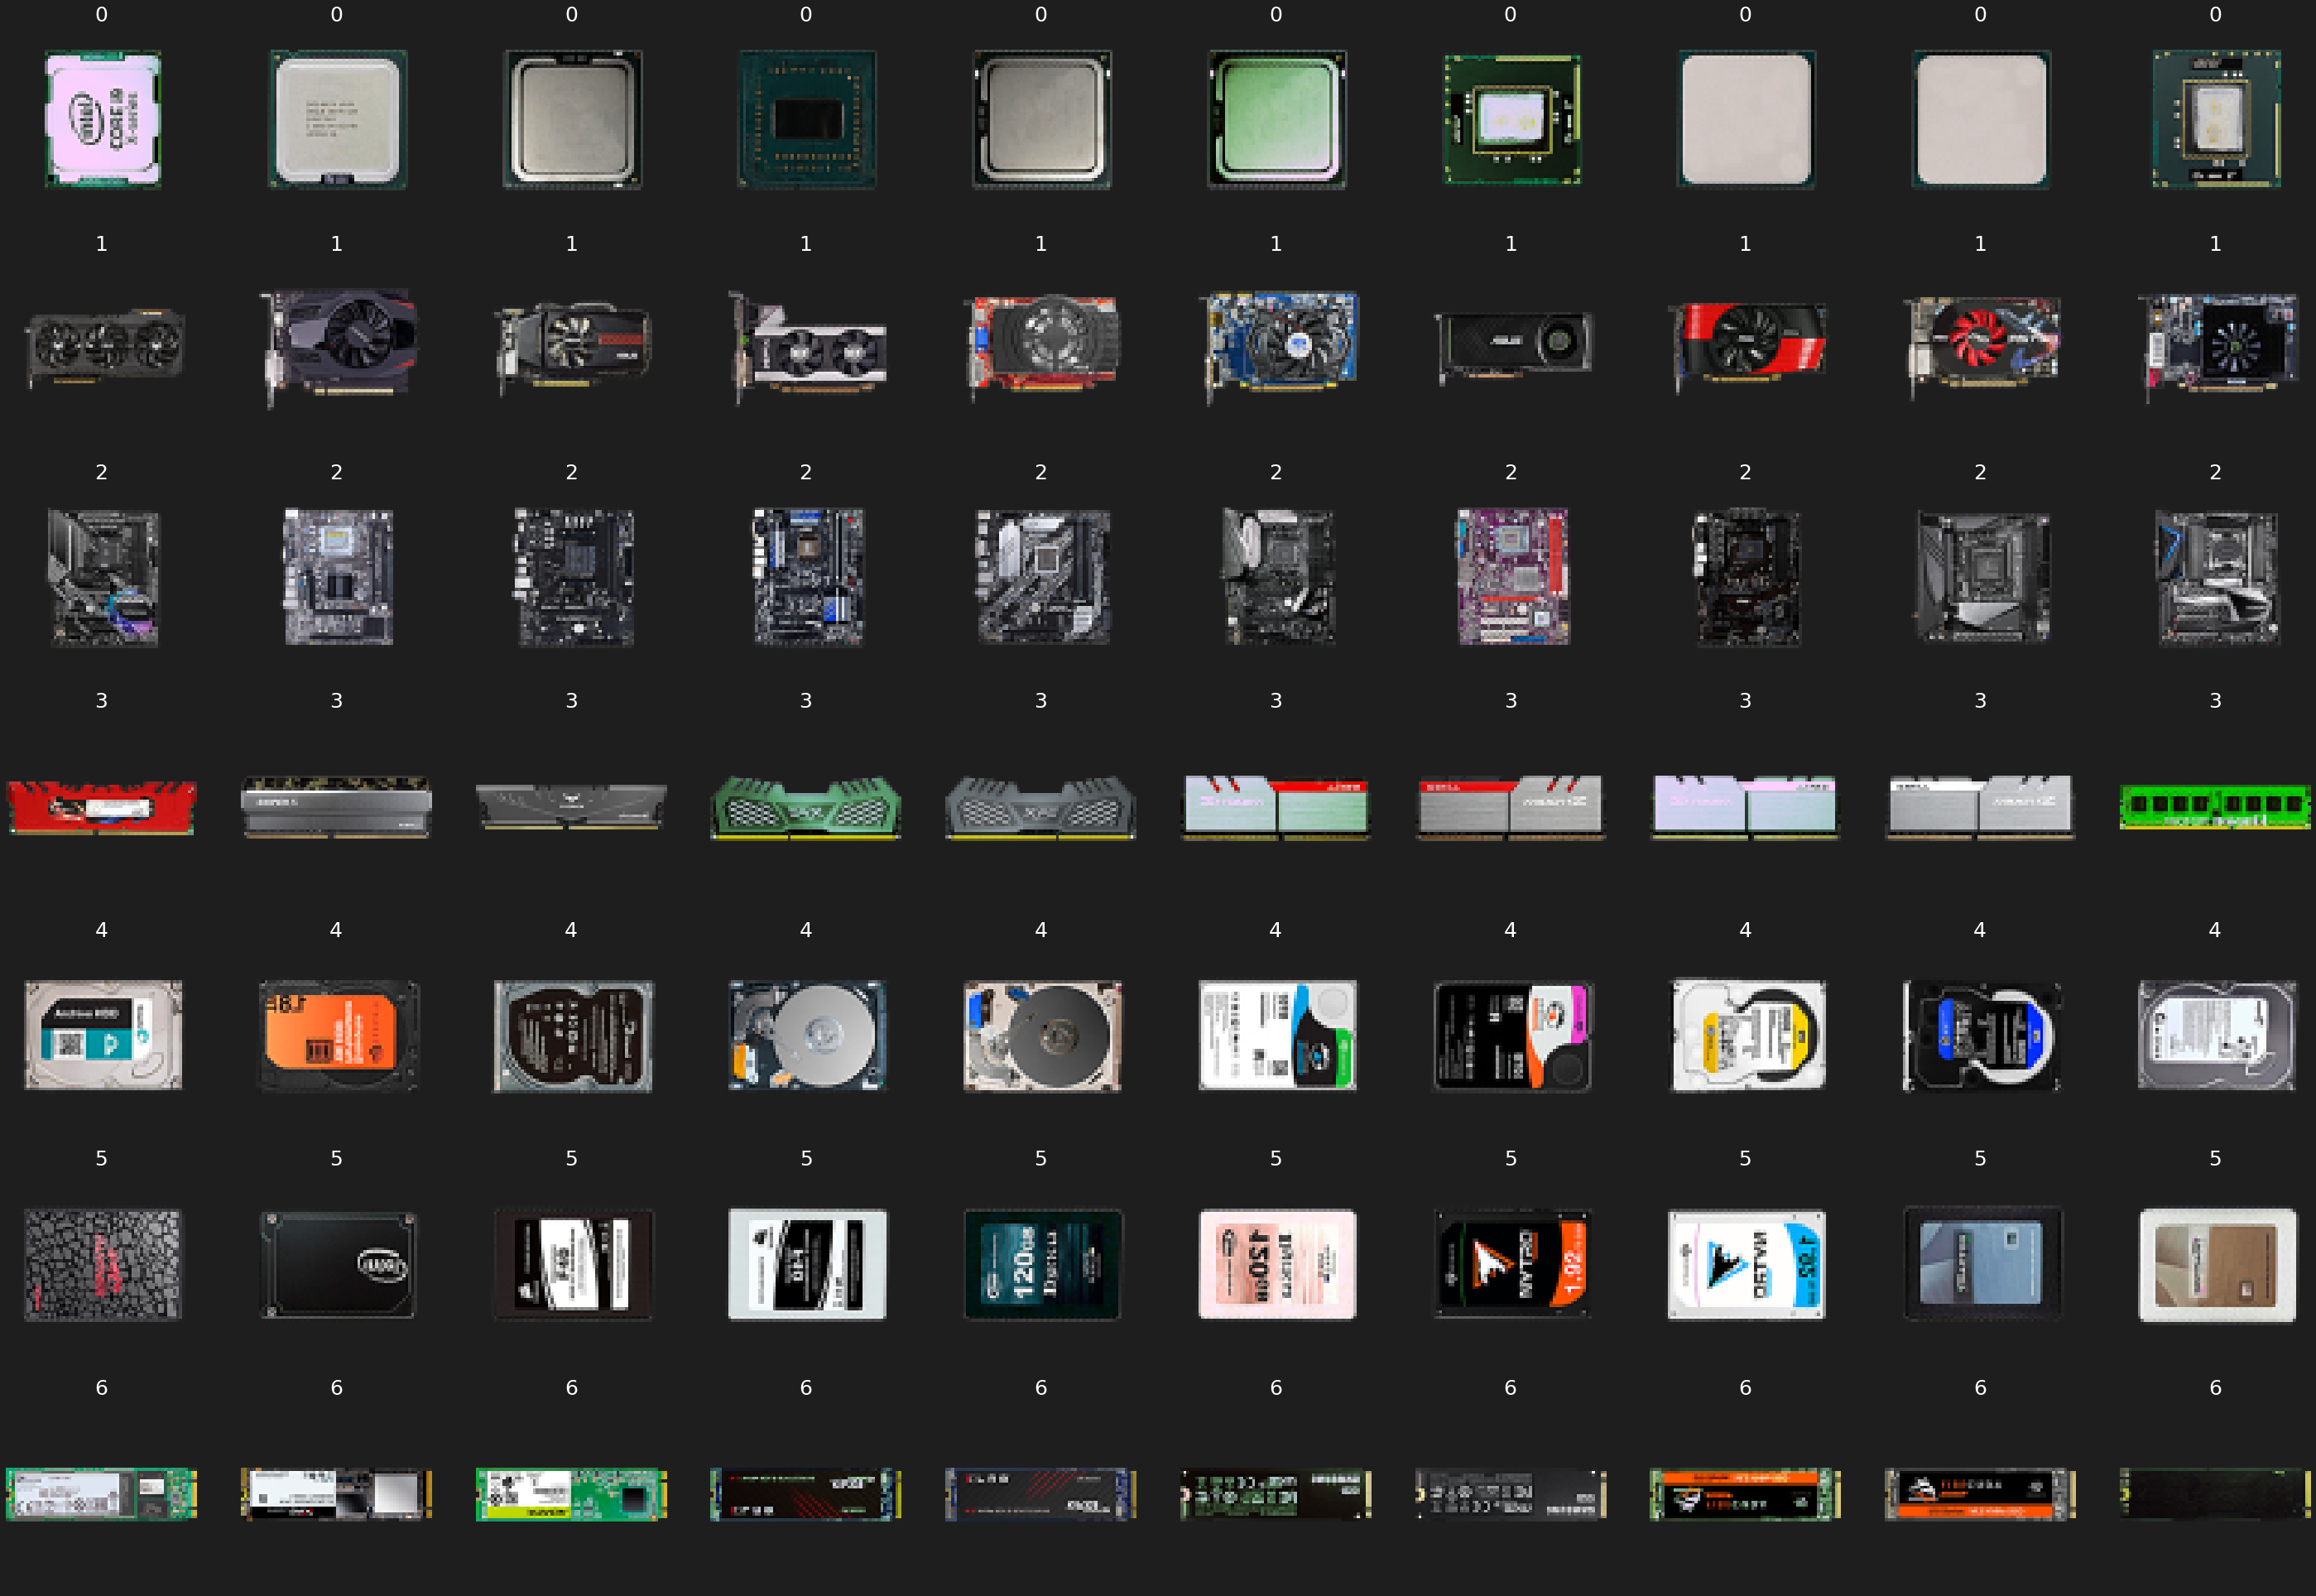

In [2]:
# auxiliary code to visualize the first 10 pictures of each category (SET-1)
plt.figure(figsize = (50, 50))
j = 0
counter_set1 = 0
counter_set2 = 0

for dir1 in os.listdir(img_train_folder_set1):
    for file in os.listdir(os.path.join(img_train_folder_set1, dir1)):
        image_path = os.path.join(img_train_folder_set1, dir1, file)  
        img = mpimg.imread(image_path)
        ax = plt.subplot(10, 10, j+1)
        ax.title.set_text(file)
        plt.axis('off')
        plt.title(dir1, fontsize = font_size, color = font_color)
        plt.imshow(img)
        j += 1
        counter_set1 += 1
        if counter_set1 == 10:
            break
    counter_set2 += 1
    counter_set1 = 0
    if counter_set2 == 7:
        break

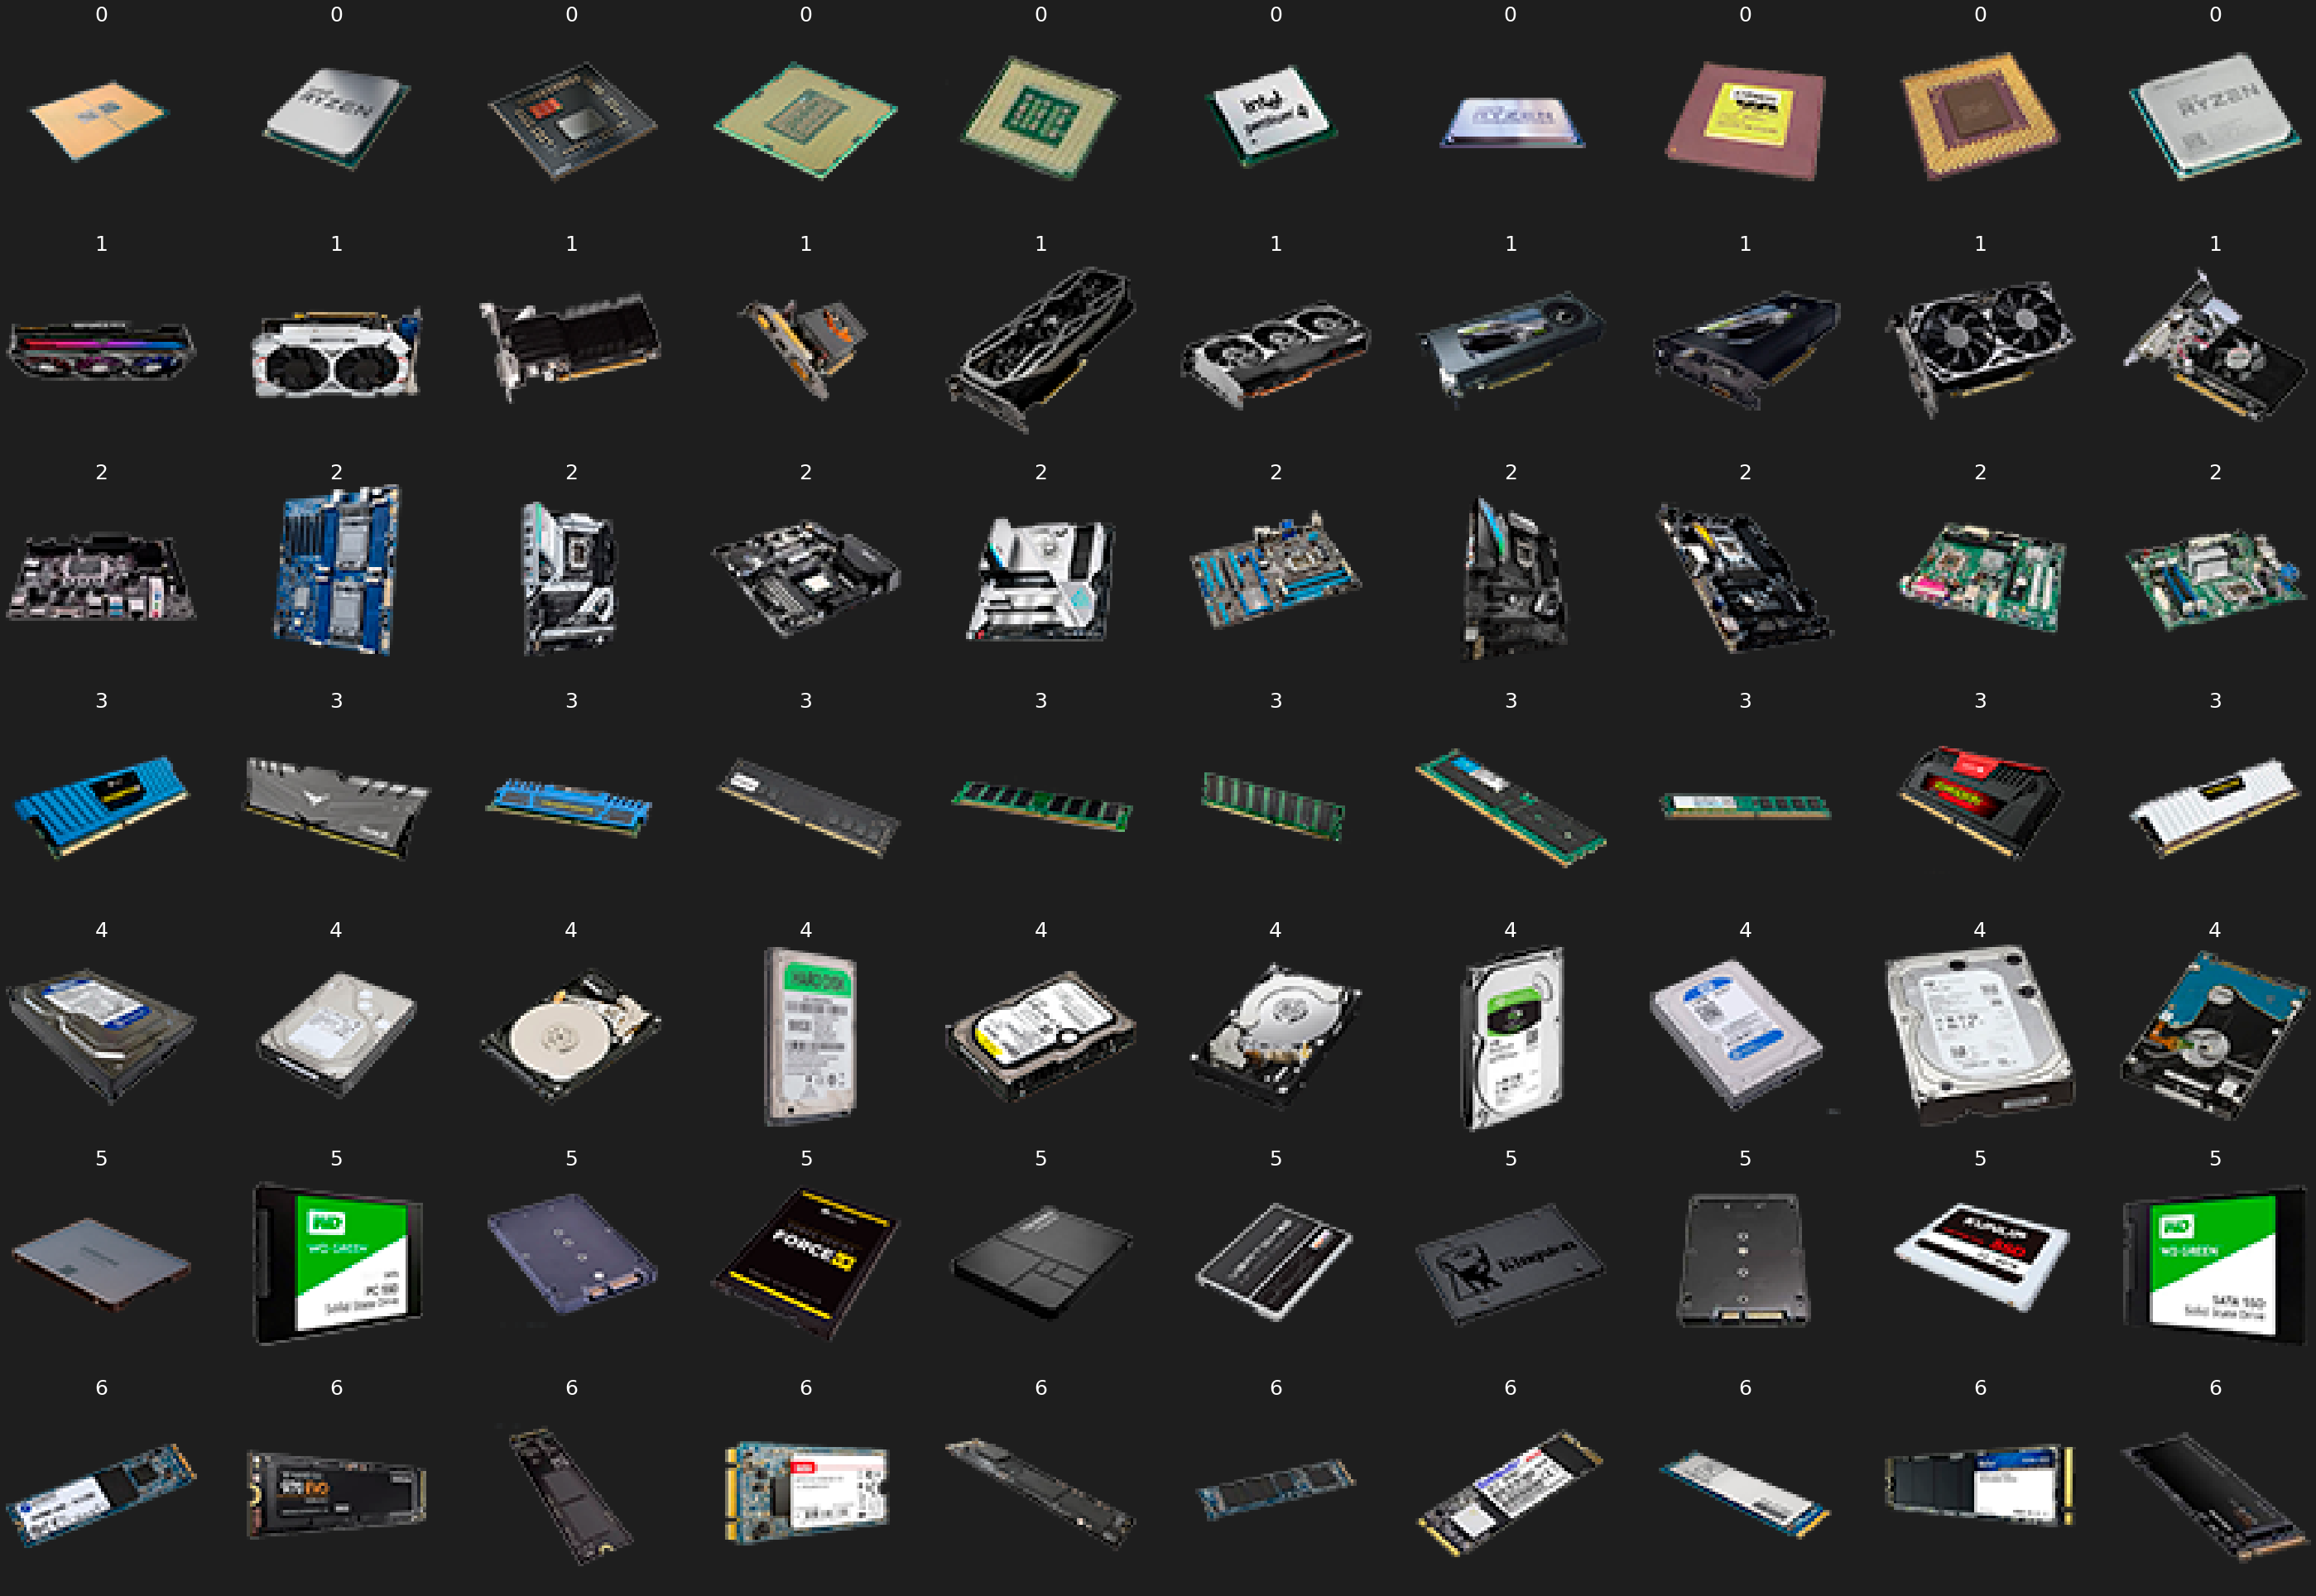

In [3]:
# auxiliary code to visualize the first 10 pictures of each category (SET-2)
plt.figure(figsize = (50, 50))
j = 0
counter_set3 = 0
counter_set4 = 0

for dir1 in os.listdir(img_train_folder_set2):
    for file in os.listdir(os.path.join(img_train_folder_set2, dir1)):
        image_path = os.path.join(img_train_folder_set2, dir1, file)  
        img = mpimg.imread(image_path)
        ax = plt.subplot(10, 10, j+1)
        ax.title.set_text(file)
        plt.axis('off')
        plt.title(dir1, fontsize = font_size, color = font_color)
        plt.imshow(img)
        j += 1
        counter_set3 += 1
        if counter_set3 == 10:
            break
    counter_set4 += 1
    counter_set3 = 0
    if counter_set4 == 7:
        break

In [4]:
# function to gather pictures and generate a numpy array (COLOR)
def create_dataset(img_folder):
   
    img_data_array = []
    class_name = []
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1, file)
            image = io.imread(image_path, as_gray = False)
            image = np.array(image)
            image = rgba2rgb(image)                      
            img_data_array.append(image)
            class_name.append(int(dir1))
    return img_data_array, class_name

In [5]:
# sets a image generator to inflate the dataset
generator = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    fill_mode='constant',
    cval=1)

In [6]:
train_valid_size = 0.80
i = 0

# dataset import
X_array1, y_array1 = create_dataset(img_train_folder_set1)
X_array2, y_array2 = create_dataset(img_train_folder_set2)

X_trainSeq1 = np.array(X_array1)
y_trainSeq1 = np.array(y_array1)

X_trainSeq2 = np.array(X_array2)
y_trainSeq2 = np.array(y_array2)

X_gen = generator.flow(X_trainSeq1, y_trainSeq1, batch_size = 1820, seed = random_state)
X_trainGen1, y_trainGen1 = X_gen.next()
X_trainSeq1Gen = np.concatenate((X_trainSeq1, X_trainGen1), axis=0)
y_trainSeq1Gen = np.concatenate((y_trainSeq1, y_trainGen1), axis=0)
while i < 10:
    X_trainGen1, y_trainGen1 = X_gen.next()
    X_trainSeq1Gen = np.concatenate((X_trainSeq1Gen, X_trainGen1), axis=0)
    y_trainSeq1Gen = np.concatenate((y_trainSeq1Gen, y_trainGen1), axis=0)
    i += 1
i = 0

X_gen = generator.flow(X_trainSeq2, y_trainSeq2, batch_size = 329, seed = random_state)
X_trainGen2, y_trainGen2 = X_gen.next()
X_trainSeq2Gen = np.concatenate((X_trainSeq2, X_trainGen2), axis=0)
y_trainSeq2Gen = np.concatenate((y_trainSeq2, y_trainGen2), axis=0)
while i < 60:
    X_trainGen2, y_trainGen2 = X_gen.next()
    X_trainSeq2Gen = np.concatenate((X_trainSeq2Gen, X_trainGen2), axis=0)
    y_trainSeq2Gen = np.concatenate((y_trainSeq2Gen, y_trainGen2), axis=0)
    i += 1

counter_set1 = X_trainSeq1Gen.shape[0]
counter_set2 = X_trainSeq2Gen.shape[0]

X_totalTrainSet = np.concatenate((X_trainSeq1Gen, X_trainSeq2Gen), axis=0)
y_totalTrainSet = np.concatenate((y_trainSeq1Gen, y_trainSeq2Gen), axis=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_totalTrainSet, y_totalTrainSet, train_size = train_valid_size, random_state = random_state, stratify = y_totalTrainSet)

del X_array1
del y_array1
del X_array2
del y_array2
del X_trainSeq1
del y_trainSeq1
del X_trainSeq2
del y_trainSeq2
del X_trainGen1
del y_trainGen1
del X_trainGen2
del y_trainGen2
del X_trainSeq1Gen
del y_trainSeq1Gen
del X_trainSeq2Gen
del y_trainSeq2Gen
del X_totalTrainSet
del y_totalTrainSet
del X_gen
gc.collect()

print('treinamento:         ', X_train.shape)
print('validação:           ', X_valid.shape)

treinamento:          (33790, 64, 64, 3)
validação:            (8448, 64, 64, 3)


In [7]:
# enumerate the classes found
class_names = ['cpu', 'gpu', 'mobo', 'ram', 'hd', 'ssd-sata', 'ssd-m2']

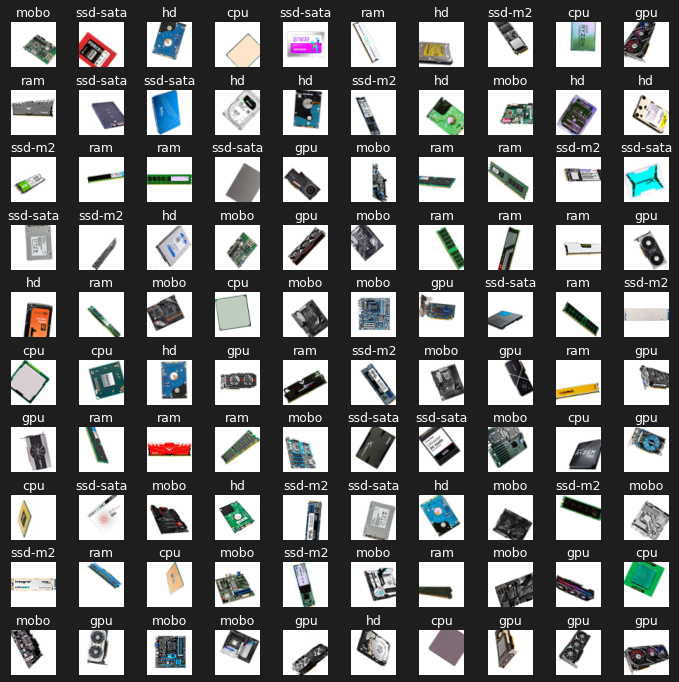

In [8]:
# train/validation/test dataset visualization (100 first items)
n_rows = 10
n_cols = 10
plt.figure(figsize = (n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index, :, :], cmap = 'binary')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize = font_size / 2, color = font_color)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

In [9]:
## CNN ##

epochs = 12

# build the neural network layers
keras.backend.clear_session() # clears the session
np.random.seed(random_state) # random tf seed, but fixed
tf.random.set_seed(random_state) # random tf seed, but fixed
if 'model' in globals():
        del model
        gc.collect()

model = keras.models.Sequential([
                keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation = 'relu', input_shape = [64, 64, 3]),           
                keras.layers.MaxPool2D(pool_size = 2),
                keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),              
                keras.layers.MaxPool2D(pool_size = 2),  
                keras.layers.Conv2D(filters = 96, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),              
                keras.layers.MaxPool2D(pool_size = 2), 
                keras.layers.Flatten(),
                keras.layers.Dropout(0.5),
                keras.layers.Dense(512, activation = 'relu'),
                keras.layers.Dropout(0.25),
                keras.layers.Dense(256, activation = 'relu'),
                keras.layers.Dropout(0.25),
                keras.layers.Dense(64, activation = 'relu'),
                keras.layers.Dense(7, activation = 'softmax')
        ])        
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
flatten (Flatten)            (None, 6144)              0

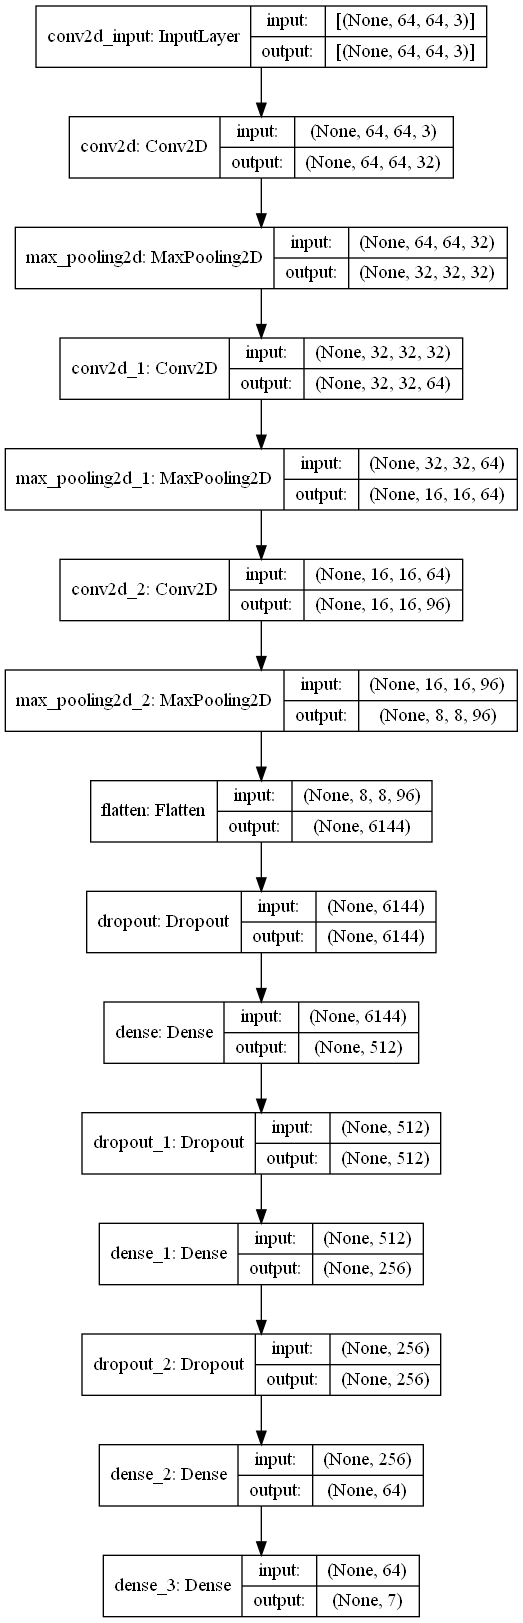

In [10]:
# prints the DNN/CNN structure
tf.keras.utils.plot_model(model, 'pc_hardware_model.png', show_shapes = True)

In [11]:
temp = round((1 - train_valid_size) * 100, 2)

# sets NADAM as the optimizer (CNN)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

run_dir1 = os.path.join(log_dir, 'cnn' + '-' + 'nadam' + '_' + 'eph' + str(epochs) + '_' + 'img' + str(X_train.shape[0] + X_valid.shape[0]) + '_' + str(64) + 'x' + str(64) + '_' + str(train_valid_size * 100) + '%' + '-' + str(temp) + '%' + '-' + '_' + time.strftime('run-%Y-%m-%d-%H-%M-%S'))
tensorboard1 = keras.callbacks.TensorBoard(run_dir1)

# trains the neural network
%time history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid), callbacks = [tensorboard1])

Epoch 1/12
1056/1056 [==============================] - 37s 29ms/step - loss: 1.3607 - accuracy: 0.4407 - val_loss: 0.9209 - val_accuracy: 0.6070
Epoch 2/12
1056/1056 [==============================] - 42s 39ms/step - loss: 0.8297 - accuracy: 0.6694 - val_loss: 0.5899 - val_accuracy: 0.7688
Epoch 3/12
1056/1056 [==============================] - 40s 38ms/step - loss: 0.5691 - accuracy: 0.7876 - val_loss: 0.3790 - val_accuracy: 0.8653
Epoch 4/12
1056/1056 [==============================] - 41s 39ms/step - loss: 0.4152 - accuracy: 0.8498 - val_loss: 0.3199 - val_accuracy: 0.8872
Epoch 5/12
1056/1056 [==============================] - 42s 40ms/step - loss: 0.3420 - accuracy: 0.8773 - val_loss: 0.2607 - val_accuracy: 0.9150
Epoch 6/12
1056/1056 [==============================] - 42s 39ms/step - loss: 0.2802 - accuracy: 0.9008 - val_loss: 0.2037 - val_accuracy: 0.9272
Epoch 7/12
1056/1056 [==============================] - 42s 40ms/step - loss: 0.2464 - accuracy: 0.9130 - val_loss: 0.1897 -

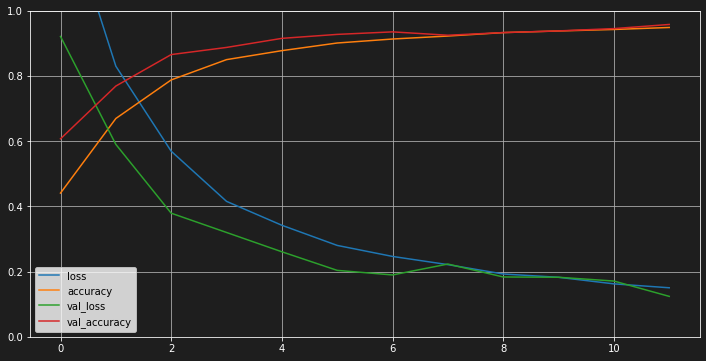

In [12]:
# prints the convergence graph
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [1]:
# loads Tensorboard
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6006

Reusing TensorBoard on port 6006 (pid 10940), started 2 days, 19:52:54 ago. (Use '!kill 10940' to kill it.)

In [3]:
# function to gather pictures and generate a numpy array (COLOR)
def create_dataset2(img_folder):
   
    counter_set1 = 0
    img_data_array = []
    class_name = []
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1, file)
            image = io.imread(image_path, as_gray = False)
            image = np.array(image, dtype = 'float32')  
            image /= 255          
            img_data_array.append(image)
            class_name.append(int(dir1))
            counter_set1 += 1
    return img_data_array, class_name, counter_set1

In [4]:
# dataset import
X_array2, y_array2, counter_set1 = create_dataset2(img_test_folder)

X_test = np.array(X_array2)
y_test = np.array(y_array2)

from sklearn.utils import shuffle
X_test, y_test = shuffle(X_test, y_test, random_state = random_state)

print('testes finais:              ', X_test.shape)

testes finais:               (145, 64, 64, 3)


In [16]:
# prints the error data
print('erro de treino:   ', history.history['loss'][-1])
print('erro de validação:', history.history['val_loss'][-1])
print('erro de teste:    ', model.evaluate(X_test, y_test, verbose = 0))

erro de treino:    0.15030601620674133
erro de validação: 0.12394449859857559
erro de teste:     [0.6417515277862549, 0.8137931227684021]


In [17]:
# probabilities for the first 100 test instances
X_new = X_test[:]
y_proba = model.predict(X_new)

In [18]:
# predicted classes for the same 100 test instances
y_pred = np.argmax(model.predict(X_new), axis = -1)

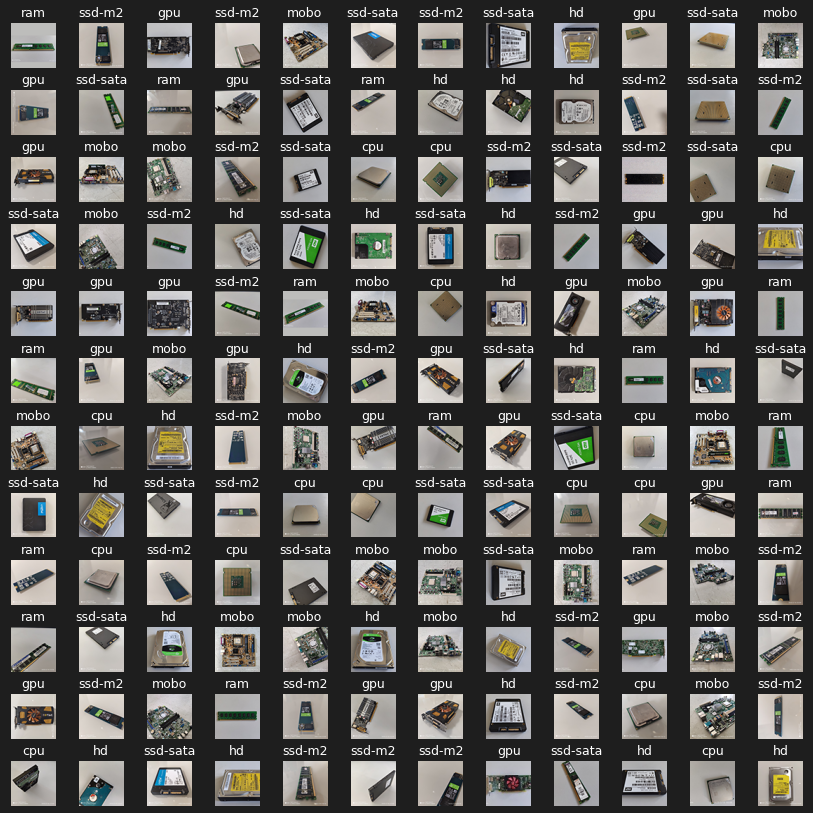

In [19]:
# test dataset evaluation view
n_rows = 12
n_cols = 12
plt.figure(figsize = (n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_new[index, :, :], cmap = 'binary')
        plt.axis('off')
        plt.title(class_names[y_pred[index]], fontsize = font_size / 2, color = font_color)
plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

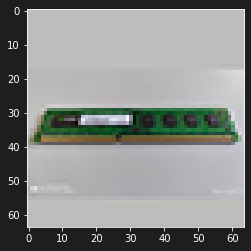

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 100.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



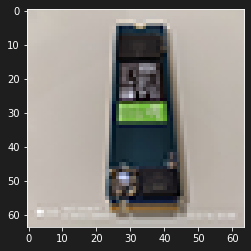

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 99.00%



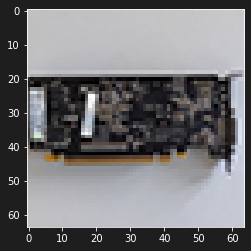

cpu - 0.00%
gpu - 100.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



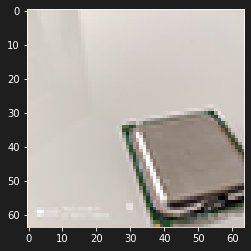

cpu - 5.00%
gpu - 1.00%
mobo - 0.00%
ram - 1.00%
hd - 2.00%
ssd-sata - 5.00%
ssd-m2 - 87.00%



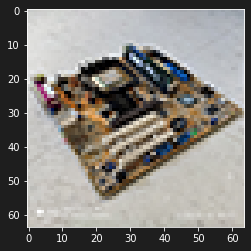

cpu - 0.00%
gpu - 40.00%
mobo - 53.00%
ram - 0.00%
hd - 1.00%
ssd-sata - 4.00%
ssd-m2 - 0.00%



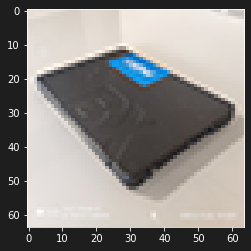

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 100.00%
ssd-m2 - 0.00%



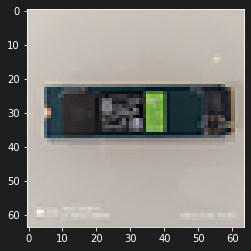

cpu - 0.00%
gpu - 1.00%
mobo - 0.00%
ram - 1.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 98.00%



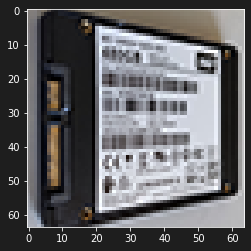

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 1.00%
ssd-sata - 99.00%
ssd-m2 - 0.00%



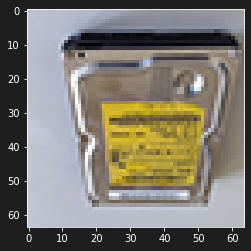

cpu - 0.00%
gpu - 0.00%
mobo - 1.00%
ram - 0.00%
hd - 97.00%
ssd-sata - 2.00%
ssd-m2 - 0.00%



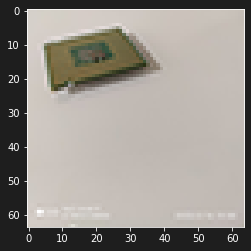

cpu - 4.00%
gpu - 59.00%
mobo - 6.00%
ram - 8.00%
hd - 0.00%
ssd-sata - 11.00%
ssd-m2 - 11.00%



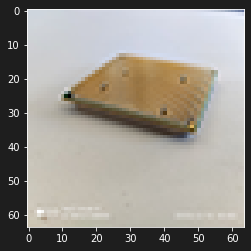

cpu - 7.00%
gpu - 1.00%
mobo - 0.00%
ram - 36.00%
hd - 0.00%
ssd-sata - 54.00%
ssd-m2 - 1.00%



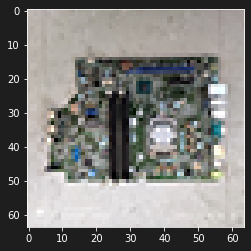

cpu - 0.00%
gpu - 0.00%
mobo - 99.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



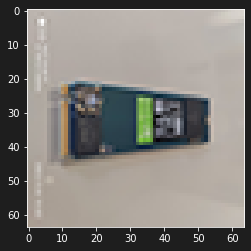

cpu - 0.00%
gpu - 77.00%
mobo - 2.00%
ram - 11.00%
hd - 0.00%
ssd-sata - 1.00%
ssd-m2 - 9.00%



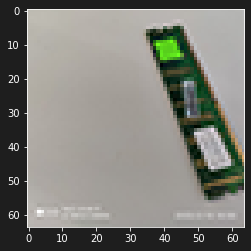

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 3.00%
hd - 6.00%
ssd-sata - 50.00%
ssd-m2 - 40.00%



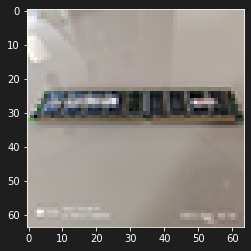

cpu - 7.00%
gpu - 3.00%
mobo - 1.00%
ram - 48.00%
hd - 1.00%
ssd-sata - 2.00%
ssd-m2 - 37.00%



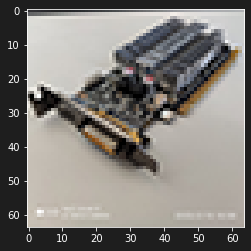

cpu - 0.00%
gpu - 98.00%
mobo - 1.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 1.00%



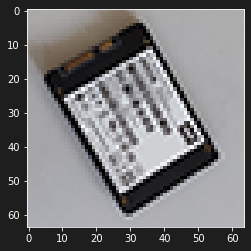

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 100.00%
ssd-m2 - 0.00%



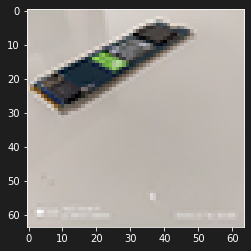

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 99.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



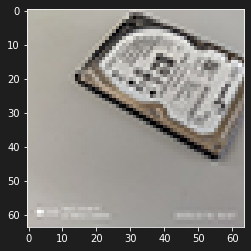

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 96.00%
ssd-sata - 4.00%
ssd-m2 - 0.00%



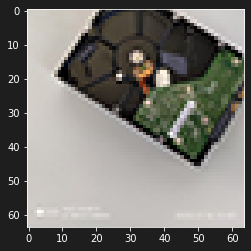

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 100.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



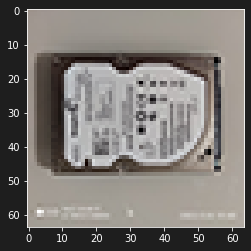

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 90.00%
ssd-sata - 9.00%
ssd-m2 - 0.00%



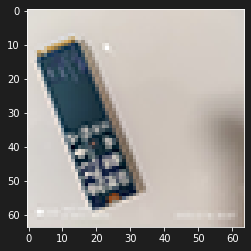

cpu - 1.00%
gpu - 5.00%
mobo - 0.00%
ram - 1.00%
hd - 0.00%
ssd-sata - 4.00%
ssd-m2 - 89.00%



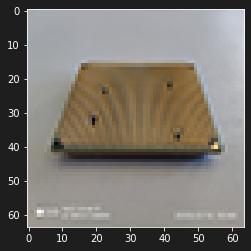

cpu - 2.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 16.00%
ssd-sata - 81.00%
ssd-m2 - 0.00%



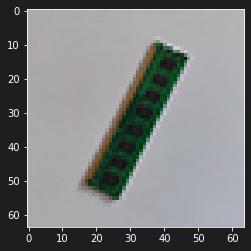

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 1.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 99.00%



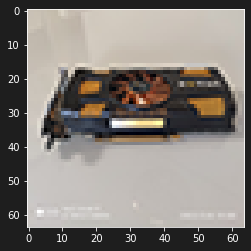

cpu - 0.00%
gpu - 100.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



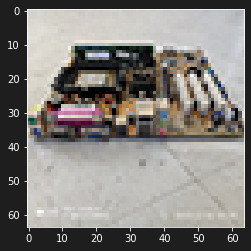

cpu - 0.00%
gpu - 16.00%
mobo - 80.00%
ram - 0.00%
hd - 3.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



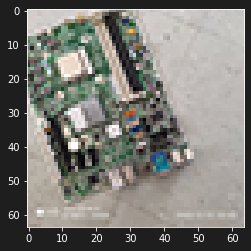

cpu - 0.00%
gpu - 0.00%
mobo - 99.00%
ram - 0.00%
hd - 1.00%
ssd-sata - 0.00%
ssd-m2 - 0.00%



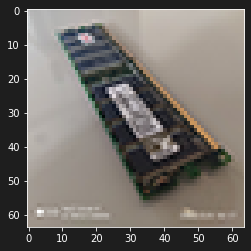

cpu - 0.00%
gpu - 4.00%
mobo - 0.00%
ram - 5.00%
hd - 0.00%
ssd-sata - 1.00%
ssd-m2 - 90.00%



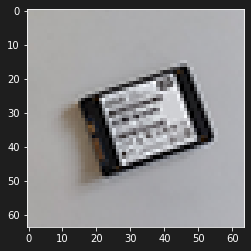

cpu - 0.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 8.00%
ssd-sata - 91.00%
ssd-m2 - 1.00%



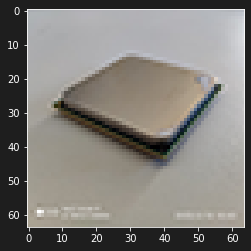

cpu - 88.00%
gpu - 0.00%
mobo - 0.00%
ram - 0.00%
hd - 0.00%
ssd-sata - 12.00%
ssd-m2 - 0.00%



In [20]:
# show probability percentage
for image_index in range(30):
    plt.imshow(X_test[image_index])
    plt.show()
    for class_name, class_id in zip(class_names, y_proba[image_index]):
        print('{} - {:.2f}%'.format(class_name, class_id.round(2) * 100))
    print()

In [ ]:
# saves the CNN neural network
model.save('cnn' + '-' + 'nadam' + '_' + 'eph' + str(epochs) + '_' + 'img' + str(X_train.shape[0] + X_valid.shape[0]) + '_' + str(64) + 'x' + str(64) + '_' + str(train_valid_size * 100) + '%' + '-' + '%' + '-' + str(temp) + '%' + '-' + str(100 - (train_valid_size * 100) - temp) + '%' + '_' + time.strftime('run-%Y-%m-%d-%H-%M-%S') + '.h5')

In [2]:
# loads saved neural network
model = keras.models.load_model(r'D:\kevin\OneDrive\Documentos\GitHub\TCC-FURG\modelos\CNN\modelo final\cnn-nadam_eph12_img42238_64x64_80.0%-20.0%-_run-2022-02-24-16-06-16.h5')

In [17]:
# prediction for the whole test dataset
y_test_pred = model.predict(X_test)

# performance mesurements
from sklearn.metrics import precision_score, recall_score, f1_score
print('precisão:     ', precision_score(y_test, np.argmax(y_test_pred, axis=1), average='weighted'))
print('sensibilidade:', recall_score(y_test, np.argmax(y_test_pred, axis=1), average='weighted'))
print('pontuação f1: ', f1_score(y_test, np.argmax(y_test_pred, axis=1), average='weighted'))

precisão:      0.8254062059879153
sensibilidade: 0.8137931034482758
pontuação f1:  0.8111528590884262
